In [1]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from imblearn.over_sampling import SMOTE

import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

Load Data

In [2]:
# Loading training dataset
df_train = pd.read_csv('data_set_ALL_AML_train.csv')
df_test = pd.read_csv('data_set_ALL_AML_independent.csv')

print(df_train.shape)
print(df_test.shape)

(7129, 78)
(7129, 70)


The data consists of 7129 rows and 78 columns for training set, and 70 columns for testing set. Each row corresponds to one of the 7129 genes, and each column represents a single patient. Therefore, each cell contains the expression level of a specific gene to a particular patient.

### Cleaning Data
we will assume that the 'call' columns, which seem to be designated for each patient, are unimportant as they do not vary significantly in values and any related information cannot be found in the paper

In [3]:
# Remove call columns in training dataset

columns_to_remove_train = [col for col in df_train if 'call' in col]
train = df_train.drop(columns_to_remove_train, axis=1)

#Remove call columns in testing dataset
columns_to_remove_test = [col for col in df_test if 'call' in col]
test = df_test.drop(columns_to_remove_test, axis=1)

In [4]:
train.columns

Index(['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '34', '35',
       '36', '37', '38', '28', '29', '30', '31', '32', '33'],
      dtype='object')

Now we will transpose the columns and rows so that 7129 genes become features, and each patient instance occupies a single row

In [5]:
# Transpose row and columns in training set
X_train = train.T

#Transpose row and columns in testing set
X_test = test.T

Let's first designate the second row containing the gene accession numbers as the column names. Then, remove both the first two rows of Gene Description and Gene Accession Number

In [6]:
# Set the second row (Gene Accession Number) as the column names
X_train.columns = X_train.iloc[1] # for training set
X_test.columns = X_test.iloc[1] # for testing set

# Drop the first two rows (Gene Description and Gene Accession Number) and reindex

X_train = X_train.iloc[2:].reset_index(drop=True) # for training set
X_test = X_test.iloc[2:].reset_index(drop=True)

print(X_train.shape)
print(X_test.shape)

(38, 7129)
(34, 7129)


As most libraries work with numerical data, let's convert data values to numeric

In [7]:
# Convert data values to numeric for training set
X_train = X_train.apply(pd.to_numeric, errors = 'coerce')

#Convert data values to numeric for testing set
X_test = X_test.apply(pd.to_numeric, errors = 'coerce')

Load Labels

In [8]:
#Load Labels
labels = pd.read_csv('actual.csv')

print(labels.shape)
labels.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [9]:
# Merge all dataset
merged_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
merged_XY = pd.concat([merged_X, labels], axis=1)

print(merged_XY.shape)
merged_XY.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,ALL
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,ALL
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,ALL
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,ALL
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,ALL


In [10]:
#Check for nulls
null_counts = merged_XY.isnull().sum().max()

print('Column with Null Values:')
print(null_counts)

Column with Null Values:
0


In [11]:
# Check for label imbalance
merged_XY['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

We have much more ALL patients than AML patients. Let's also convert labels to numeric values with ALL as 0 and AML as 1

In [12]:
#Replace values in the 'cancer' column with 0 for 'ALL' and 1 for 'AML'
cancer_mapping = {'ALL':0, 'AML':1}
merged_XY['cancer'] = merged_XY['cancer'].map(cancer_mapping)

In [13]:
print(merged_XY.shape)
merged_XY.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


Since there are no null values, we don't need to worry about them. Now, as t-tests and many machine learning models perform better with normalized data, let's scale the data. We will use the dataframe 'merged_XY. However, since label columns do not need to be scaled, we will first frop the label columns and then scale only the gene columns.

In [14]:
#Exclude patient and cancer columns
gene_columns = merged_XY.columns.drop(['patient','cancer'])
merged_X = merged_X[gene_columns]

#Create a StandardScaler object
scaler = StandardScaler()

#Fit the scaler to the data (calculate mean and standard deviation)
scaler.fit(merged_X)

#Transform the data using the fitted scaler
normalized_merged_X = scaler.transform(merged_X)

#Concert back to pandas dataframe
normalized_merged_X = pd.DataFrame(normalized_merged_X, columns = gene_columns)

#Concatenate the normalized gene expression data with the patient and cancer columns
normalized_merged_XY = pd.concat([normalized_merged_X, merged_XY[['patient','cancer']]], axis=1)


Later in t-test, we need separate data of ALL and AML patients. Thus, let's create the two separate normalized dataframes

In [15]:
# Create separate normalized DataFrames for ALL and AML patients

normalized_merged_XY_ALL = normalized_merged_XY[normalized_merged_XY['cancer']==0]
normalized_merged_XY_AML = normalized_merged_XY[normalized_merged_XY['cancer']==1]

print(normalized_merged_XY_ALL.shape)
print(normalized_merged_XY_AML.shape)

(47, 7131)
(25, 7131)


## Statistical analysis of gene expression using t-test

We want to identify genes that play a crucial role in distinguishing between ALL and AML. To achieve this, we need to select genes where there is a significant difference between the means of the two groups. The Student's t-test is a statistical hypothesis test used to determine if there is a significant difference between the means of two groups. The t-test produces a t-value, which measures the difference between the means of the two groups relative to the variation in the data. The t-value is then used to calculate the p-value, which represents the probability of observing the observed difference in means (or more extreme) if the null hypothesis (no difference in means) is true. A significance level of p-value was chosen, commonly 0.05, to determine if the observed difference in means is statistically significant. If the p-value is less than the chosen significance level, then the null hypothesis is rejected, and the gene is considered significantly differentially expressed between the two groups. The smaller the p-value, the stronger the evidence against the null hypothesis, indicating that there is a significant difference between the groups.

In [16]:
# Drop 'patient' and 'cancer' columns for each normalized_merged_XY_ALL and normalized_merged_XY_AML

normalized_merged_X_ALL = normalized_merged_XY_ALL.drop(['patient', 'cancer'], axis=1)
normalized_merged_X_AML = normalized_merged_XY_AML.drop(['patient','cancer'], axis=1)

Since we do not need the label columns, we have removed those columns from both ALL and AML datasets. Now, let's compute t-value and p-value for each gene and create dataframes for each of them.

Why t-test not ANOVA? ChatGPT said: Choosing between a t-test and ANOVA depends on the specific characteristics of your data and the questions you're trying to answer. Here's why a t-test might be more appropriate than ANOVA for your specific case of comparing gene expression levels between ALL and AML:

1. Number of Groups: T-Test:- It is designed to compare the means of two groups. In your analysis, you are directly comparing the expression levels of genes between two specific leukemia types (ALL vs AML). ANOVA:- It is used to compare means across three or more groups. If you were comparing multiple leukemia types or other conditions, ANOVA would be more suitable.

2. Focus on Specific Comparisons: T-Test:- It allows you to focus on pairwise comparisons between the two groups, which can provide a clear understanding of how specific genes differ in expression between ALL and AML. ANOVA:- While it can provide a broader analysis, it doesn't specify which groups differ unless you follow it with post-hoc tests. This could add complexity and require additional steps to interpret results.

3. Simplicity and Clarity: T-Test:- The results from a t-test are straightforward: you get a t-statistic and a p-value that directly indicate whether the difference in means is significant for each gene being tested. ANOVA: While ANOVA gives an overall significance for the differences among groups, the interpretation becomes more complex if you have to conduct post-hoc tests to identify which groups are significantly different.

4. Interpretability: The t-test results are often easier to interpret and communicate, especially in a clinical or biological context where stakeholders might not be familiar with more complex statistical methods. You can simply state that 'Gene X is significantly more expressed in AML compared to ALL' based on t-test results.

5. Assumptions: Both tests have similar assumptions regarding normality and variance homogeneity, but since you are only daling with two groups, the assumptions are simpler to validate with a t-test.

In [17]:
# Perform t-test for each gene

results = []
for gene in normalized_merged_X_ALL.columns:
    t_value, p_value = ttest_ind(normalized_merged_X_ALL[gene], normalized_merged_X_AML[gene], 
                                 equal_var=False)
    results.append((gene, t_value, p_value))
    
# Convert results list to DataFrame
df_results = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# Adjust p-values for multiple testing using False Discovery Rate (FDR) correction
rejected, adjusted_p_values = fdrcorrection(df_results['P_Value'])

In [18]:
df_results.head()

,Gene Accession Number,T_Value,P_Value
0,AFFX-BioB-5_at,-1.025408,0.309136
1,AFFX-BioB-M_at,-1.379648,0.172679
2,AFFX-BioB-3_at,-1.011032,0.315506
3,AFFX-BioC-5_at,-2.422568,0.018676
4,AFFX-BioC-3_at,0.029392,0.976665


#### Flitering out significant genes for the ALL and AML classification

We will filter genes with p-values less than 0.05, then sort them based on the p-values. Smaller p-value means that it has a bigger importance on distinguishing between AML and ALL patients

In [19]:
# Set the threshold for significance level
threshold = 0.05

#Get the list of significant genes based on the threshold
significant_genes = df_results[rejected & (adjusted_p_values < threshold)]

#Sort significant genes based on p-values
significant_genes = significant_genes.sort_values(by='P_Value')

#Add rank to significant genes DataFrame
significant_genes['Rank'] = significant_genes['P_Value'].rank()

#Display the results

print('Total Genes: 7129')
print('Significant Genes (T-test):', len(significant_genes))

Total Genes: 7129
Significant Genes (T-test): 34


In [20]:
# Function to calculate Cohen's d
def cohen_d(x, y):
    "Calculate Cohen's d for two independent samples."
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    mean_diff = np.mean(x) - np.mean(y)
    s = np.sqrt(((nx - 1)* np.std(x, ddof=1) ** 2 + (ny - 1)* np.std(y, ddof=1) ** 2) / dof)
    return mean_diff/s

# Add Cohen's d calculation to results DataFrame
cohen_d_results = []
for gene in normalized_merged_X_ALL.columns:
    d = cohen_d(normalized_merged_X_ALL[gene], normalized_merged_X_AML[gene])
    cohen_d_results.append(d)
    
# Add Cohen's d to df_results
df_results['Cohen_D'] = cohen_d_results

# Display results
print(df_results[['Gene Accession Number', 'T_Value', 'P_Value', 'Cohen_D']].head())

  Gene Accession Number   T_Value   P_Value   Cohen_D
0        AFFX-BioB-5_at -1.025408  0.309136 -0.232138
1        AFFX-BioB-M_at -1.379648  0.172679 -0.313732
2        AFFX-BioB-3_at -1.011032  0.315506 -0.213731
3        AFFX-BioC-5_at -2.422568  0.018676 -0.572266
4        AFFX-BioC-3_at  0.029392  0.976665  0.007151


AAFX-BioC-5_at appears to be a key gene with both statistical significance (P<0.05) and a medium effect size (Cohen's d= -0.572266). This gene could be a candidate for further investigation in the context of distinguishing between ALL and AML. The other genes in your results do not show statistically significant differences, although they may still be of interest depending on the biological context or if more data is gathered.

In [21]:
# Convert results list to DataFrame
df_results1 = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

#Adjust p-values for multiple testing using False Discovery Rate (FDR) correction
rejected, adjusted_p_values = fdrcorrection(df_results['P_Value'])

#Add adjusted p-values to results DataFrame
df_results1['Adjusted_P_Value'] = adjusted_p_values

# Select significant genes based on adjusted p-value threshold (e.g., 0.05)
significant_genes1 = df_results1[df_results1['Adjusted_P_Value'] < 0.05]

#Print significant genes
print('Significant Genes:')
print(significant_genes)

#--- Add Hypothesis Testing Summary Here ---

#Hypothesis testing summary

for gene in significant_genes['Gene Accession Number']:
    mean_ALL = normalized_merged_X_ALL[gene].mean()
    mean_AML = normalized_merged_X_AML[gene].mean()
    print(f'Hypothesis: The mean expression of {gene} in ALL is different from AML')
    print(f'Mean ALL: {mean_ALL}, Mean AML: {mean_AML}')

Significant Genes:
     Gene Accession Number   T_Value   P_Value  Rank
3300             U49248_at  5.074976  0.000004   1.0
4534             X74262_at  4.800367  0.000009   2.0
5253             D38073_at  4.759275  0.000010   3.0
5351             M69181_at  4.597115  0.000022   4.0
1305             L13278_at  4.549869  0.000022   5.0
4195             X17042_at -4.746617  0.000037   6.0
378              D32050_at  4.357197  0.000045   7.0
531              D63874_at  4.306755  0.000054   8.0
4660             X81372_at  4.294243  0.000057   9.0
2640             U05237_at  4.257756  0.000063  10.0
2241             M80254_at -4.688971  0.000063  11.0
6280           M31211_s_at  4.258540  0.000067  12.0
1927        M31303_rna1_at  4.227150  0.000072  13.0
5417             U47077_at  4.157827  0.000092  14.0
3800             U79734_at -4.239328  0.000100  15.0
2347             M91432_at  4.109578  0.000106  16.0
4327             X59417_at  4.086845  0.000128  17.0
1259             L09717_at 

In [22]:
significant_genes_Acc = significant_genes['Gene Accession Number']

#Extracting gene expression data
significant_genes_data_all = normalized_merged_XY_ALL[significant_genes_Acc]
significant_genes_data_aml = normalized_merged_XY_AML[significant_genes_Acc]

Heatmap of filtered genes for ALL

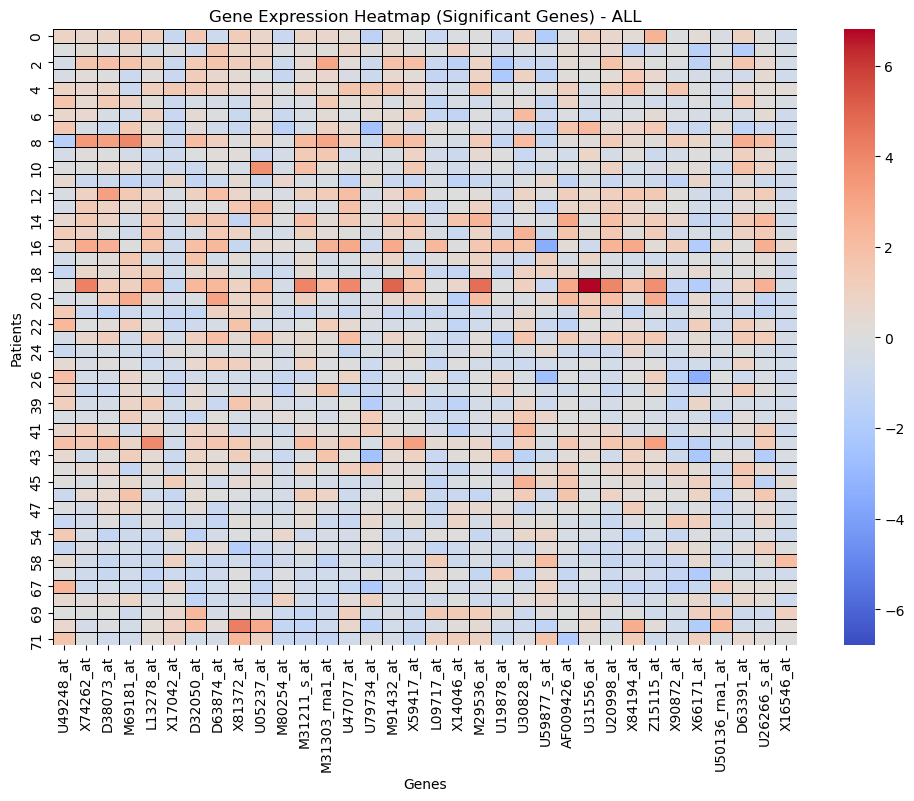

In [23]:
# For the comparison, use the same maximum absolute expression value for ALL and AML patients
max_abs_value_all = max(abs(significant_genes_data_all.values.max()),abs(significant_genes_data_all.values.min()))

#Generate heatmap for AML patients
plt.figure(figsize=(12,8))
sns.heatmap(significant_genes_data_all, cmap='coolwarm', linewidth=0.5, linecolor='black',
            vmin=-max_abs_value_all, vmax=max_abs_value_all, center=0)
plt.title('Gene Expression Heatmap (Significant Genes) - ALL')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

Heatmap of filtered genes for AML

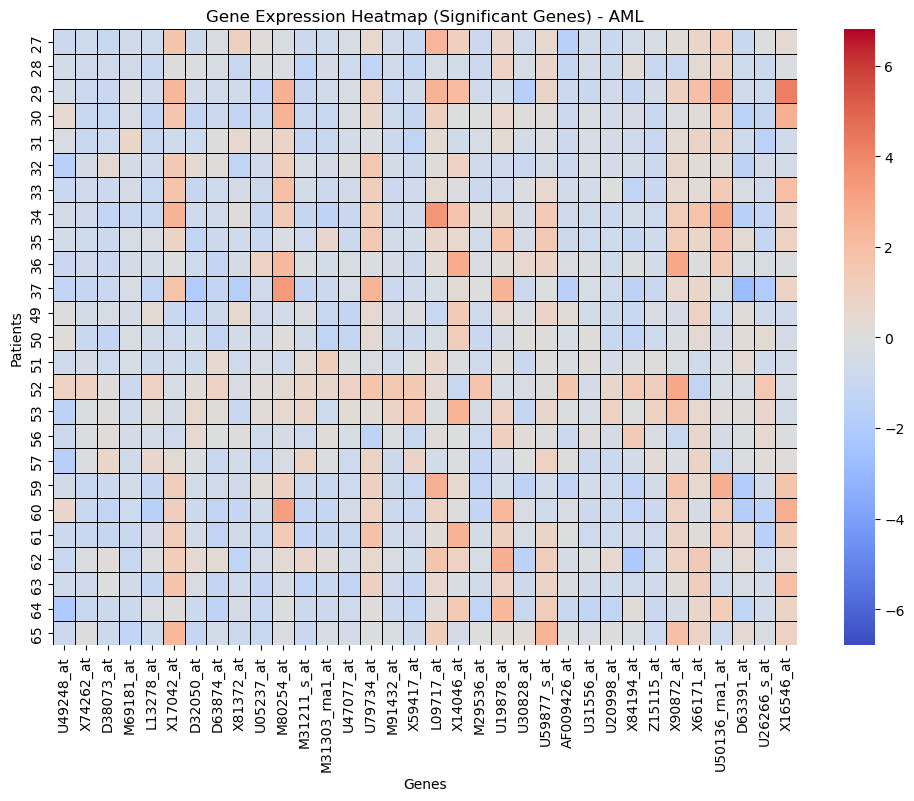

In [24]:
max_abs_value_aml = max(abs(significant_genes_data_aml.values.max()),
                       abs(significant_genes_data_aml.values.min()))

#Generate Heatmap for AML patients
plt.figure(figsize=(12,8))
sns.heatmap(significant_genes_data_aml, cmap='coolwarm', linewidth=0.5,
           linecolor = 'black', vmin=-max_abs_value_all, vmax = max_abs_value_all, center=0)

plt.title('Gene Expression Heatmap (Significant Genes) - AML')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

In general, more warm color can be observed in ALL patients, whereas more cool color can be observed in AML patients. This suggests increased gene expression level in ALL patients. The color difference is particularly noticeable among top genes on the left side of the x-axis.

#### Extraction of data corresponding to the Top 3 key genes

Let's utilize the top 3 significant genes for the classification. We will extract the corresponding data from the normalized dataset 'normalized_merged_XY'

#### Histogram and KDE plot for the Top 3 Key Genes

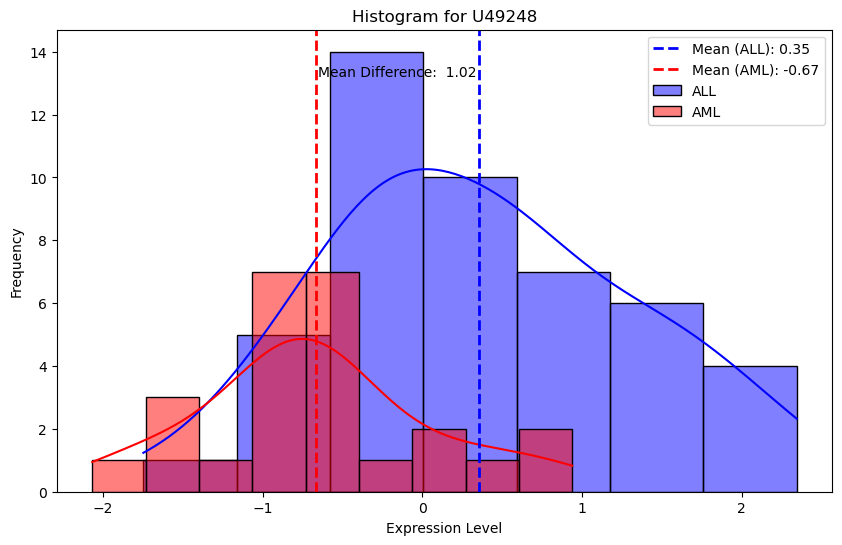

In [25]:
#Select gene expression data for both cancer types
gene_selected = 'U49248_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

#Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

#Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

#Plot histogram for both cancer types
plt.figure(figsize = (10,6))

#Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='blue', label='ALL', kde=True)

#Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='red', label='AML', kde=True)

#Annotate mean values
plt.axvline(mean_expression_all, color='blue', linestyle='dashed', linewidth=2, 
           label=f'Mean (ALL): {mean_expression_all:.2f}')

plt.axvline(mean_expression_aml, color='red', linestyle='dashed', linewidth=2, 
           label=f'Mean (AML): {mean_expression_aml:.2f}')

#Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml)/2, plt.gca().get_ylim()[1]*0.9, 
        f'Mean Difference: {mean_difference: .2f}', ha='center')

#Set Labels and Title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for U49248')

#Add Legend
plt.legend()

#Show plot
plt.show()

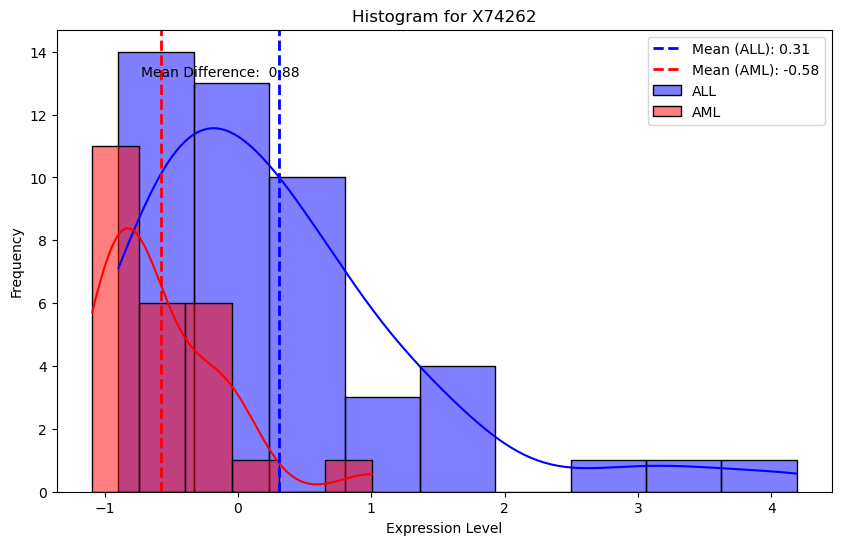

In [26]:
# Select gene expression data for both cancer types
gene_selected = 'X74262_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

#Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

#Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

#Plot histogram for both cancer types
plt.figure(figsize = (10,6))

#Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='blue', label='ALL', kde=True)

#Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='red', label='AML', kde=True)

#Annotate mean values
plt.axvline(mean_expression_all, color='blue', linestyle='dashed', linewidth=2, 
           label=f'Mean (ALL): {mean_expression_all:.2f}')

plt.axvline(mean_expression_aml, color='red', linestyle='dashed', linewidth=2, 
           label=f'Mean (AML): {mean_expression_aml:.2f}')

#Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml)/2, plt.gca().get_ylim()[1]*0.9, 
        f'Mean Difference: {mean_difference: .2f}', ha='center')

#Set Labels and Title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for X74262')

#Add Legend
plt.legend()

#Show plot
plt.show()

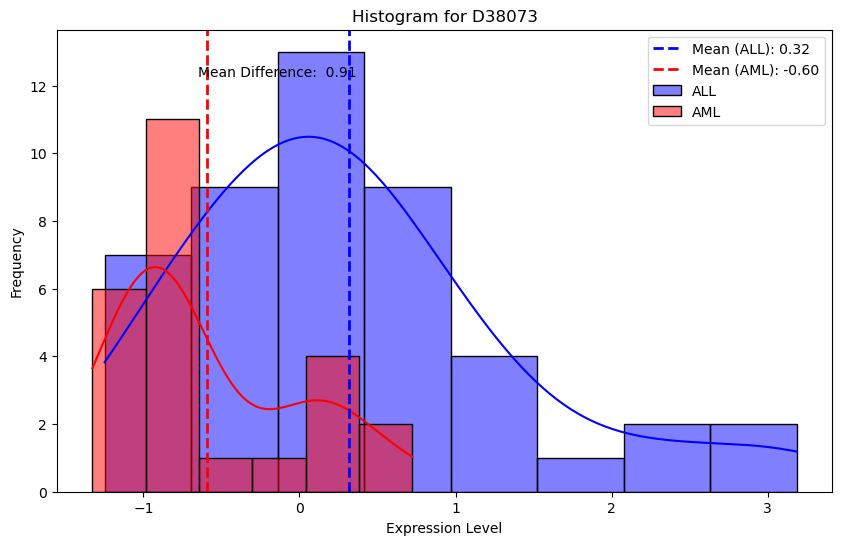

In [27]:
# Select gene expression data for both cancer types
gene_selected = 'D38073_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

#Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

#Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

#Plot histogram for both cancer types
plt.figure(figsize = (10,6))

#Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='blue', label='ALL', kde=True)

#Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='red', label='AML', kde=True)

#Annotate mean values
plt.axvline(mean_expression_all, color='blue', linestyle='dashed', linewidth=2, 
           label=f'Mean (ALL): {mean_expression_all:.2f}')

plt.axvline(mean_expression_aml, color='red', linestyle='dashed', linewidth=2, 
           label=f'Mean (AML): {mean_expression_aml:.2f}')

#Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml)/2, plt.gca().get_ylim()[1]*0.9, 
        f'Mean Difference: {mean_difference: .2f}', ha='center')

#Set Labels and Title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for D38073')

#Add Legend
plt.legend()

#Show plot
plt.show()

## Gene Information for the Top 3 Key Genes

- ABCC2 Gene (U49248): The ABCC2 gene provides instructions for making a protein called 'ATP binding cassette subfamily C member 2'. ABCC2 is a part of a family of multidrug resistance proteins responsible for transporting various substances out of cells.

- RBBP4 Gene (X74262): The RBBP4 gene encodes for a protein called 'Retinoblastoma Binding Protein 4'. RBBP4 is a nuclear protein belonging to the subfamily of WD-repeat proteins involved in histone acetylation, chromatin assembly/remodelling, transcriptional repression/silencing.

- MCM3 Gene (D38073): The MCM3 gene encodes a protein known as 'minichromosome maintenance complex component 3'. MCM3 is a member of the protein family essential for the initiation and elongation phases of DNA replication in eukaryotic cells.

## Classification

In [28]:
# Select top n genes
top_n_genes = significant_genes.head(3)['Gene Accession Number']

#Select data for the top 50 genes form normalized_merged_XY
top_n_data = normalized_merged_XY[top_n_genes]

print(top_n_data.shape)

(72, 3)


In [29]:
top_n_data.head()

,U49248_at,X74262_at,D38073_at
0,0.824753,0.596117,0.796240
1,-0.021115,0.361579,-0.294445
2,-0.409757,1.655280,1.867749
3,-0.249728,0.195656,0.043548
4,0.813323,0.593622,0.690767


#### Splitting the data into train and test sets

We will split the data into a training set of size 38 and a test set of size 34. These sets are the scaled versions of the train and test sets we obtained initially.

In [30]:
# Splitting the data into train and test sets

train_size = 38
normalized_X_train = top_n_data.iloc[:train_size, :]
normalized_X_test = top_n_data.iloc[train_size:, :]

# Check the shapes of the train and test sets

print('Train set shape:', normalized_X_train.shape)
print('Test set shape:', normalized_X_test.shape)

Train set shape: (38, 3)
Test set shape: (34, 3)


In [31]:
normalized_X_train.head()

,U49248_at,X74262_at,D38073_at
0,0.824753,0.596117,0.796240
1,-0.021115,0.361579,-0.294445
2,-0.409757,1.655280,1.867749
3,-0.249728,0.195656,0.043548
4,0.813323,0.593622,0.690767


In [32]:
#Split target labels for training and testing

cancer_target = labels.iloc[:,1]
y_train = cancer_target[:38] #Target labels for training
y_test = cancer_target[38:] #Target labels for testing

In [33]:
# Check for labels in train set
y_train.value_counts()

ALL    27
AML    11
Name: cancer, dtype: int64

In [34]:
# Check for labels in test set
y_test.value_counts()

ALL    20
AML    14
Name: cancer, dtype: int64

Balancing the labels using SMOTE

In [35]:
print('Before Upsampling:-')
print(Counter(y_train))

#Use SMOTE to oversample
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(normalized_X_train, y_train)

print('After Upsampling:-')
print(Counter(y_train_ov))

Before Upsampling:-
Counter({'ALL': 27, 'AML': 11})
After Upsampling:-
Counter({'ALL': 27, 'AML': 27})


## Models
For the classification, pretrained model of Naive Bayes, Logistic Regression, and SVM were used. In addition, for model evaluation, several metrics including accuracy, True Positive Rate(TPR) and True Negative Rate(TNR) were used. In our context, those metrics signify the following:
- Accuracy: the proportion of correctly classified patients (both ALL and AML) out of all patients
- True Positive Rate (TPR/Recall): the proportion of correctly classified AML patients out of all actual AML patients
- True Negative Rate (TNR/Specificity): the proportion of correctly classified ALL patients out of all actual ALL patients

NAIVE BAYES

Naive Bayes accuracy: 0.735
True Positive Rate (Recall) for AML class: 0.571
True Negative Rate (Specificity) for ALL class: 0.85


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

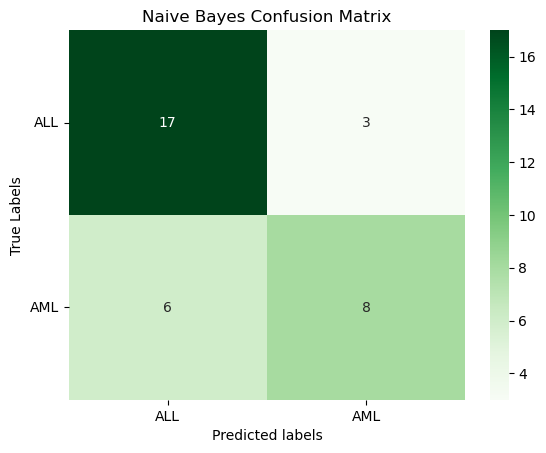

In [36]:
# Create a Gaussian classifier
nb_model = GaussianNB()

# Fit the Naive Bayes model on the training data
nb_model.fit(X_train_ov, y_train_ov)

# Predict labels for the testing data
nb_pred = nb_model.predict(normalized_X_test)

# Evaluate the accuracy of the Naive Bayes classification
print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))

# Compute confusion matrix
cm_nb = confusion_matrix(y_test,nb_pred)

# Extract true positives (TP), false positive (FP), true negatives (TN). and false negatives (FN) 
# from confusion matrix

TN, FP, FN, TP = cm_nb.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP/ (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN/ (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True Labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(['ALL','AML'])
ax.yaxis.set_ticklabels(['ALL','AML'], rotation=360)


LOGISTIC REGRESSION

Best Parameters:
 {'C': 10, 'penalty': 'l2'}
Logistic Regression accuracy: 0.794
True Positive Rate (Recall) for AML class: 0.714
True Negative Rate (Specificity) for ALL class: 0.85


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

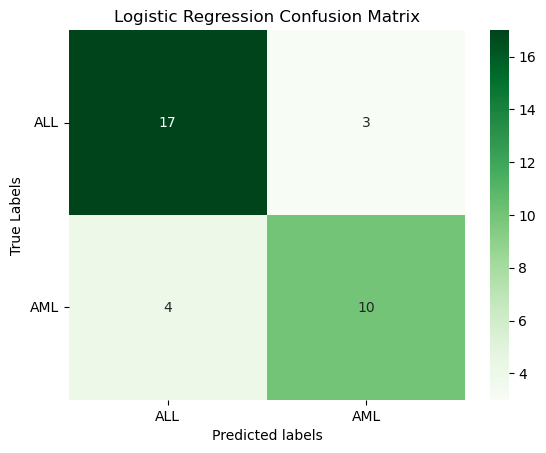

In [37]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the grid of hyperparameters
log_grid = {'C':[1e-03, 1e-2, 1e-1, 1, 10],
           'penalty':['l1', 'l2']}

# Create a logistic regression estimator
log_estimator = LogisticRegression(solver='liblinear')

# Create a grid search object
log_model = GridSearchCV(estimator=log_estimator,
                        param_grid=log_grid,
                        cv=3,
                        scoring='accuracy')

# Fit the grid search to find the best parameters
log_model.fit(X_train_ov, y_train_ov)

# Print the best parameters found by the grid search
print('Best Parameters:\n', log_model.best_params_)

# Select the best logistic regression model
best_log = log_model.best_estimator_

# Make predictions using the optimized model
log_pred = best_log.predict(normalized_X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, log_pred)
print('Logistic Regression accuracy:', round(accuracy,3))

# Compute confusion matrix
cm_log = confusion_matrix(y_test, log_pred)

# Extract true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) 
# from confusion matrix
TN, FP, FN, TP = cm_log.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP/ (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN/ (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

#Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True Labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(['ALL','AML'])
ax.yaxis.set_ticklabels(['ALL','AML'], rotation=360)

Feature Importance:
X74262_at:-2.889177627519511
U49248_at:-2.8720170974339556
D38073_at:-2.478949069751547


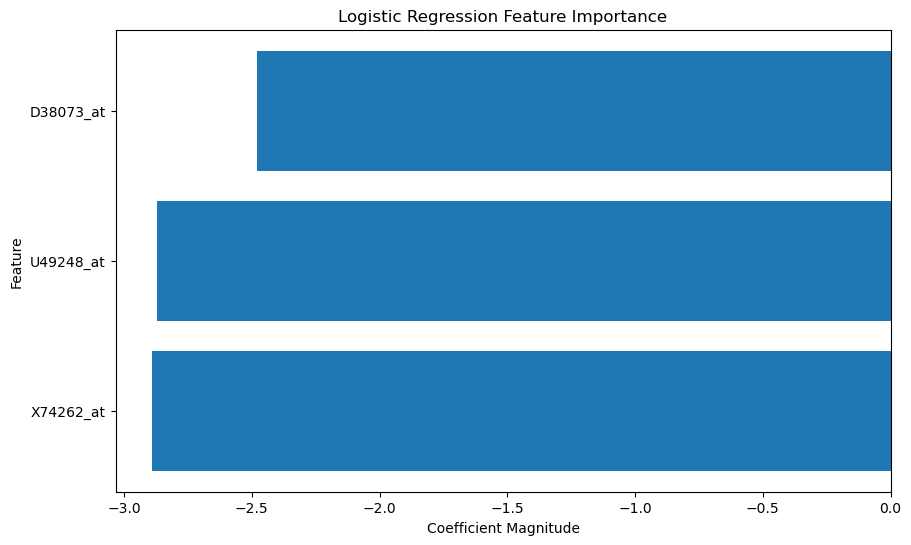

In [38]:
# Extract feature importance (coefficients)
feature_importance = best_log.coef_[0]

# Match feature importance with feature names
feature_names = X_train_ov.columns.tolist()
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]),
                                  reverse=True)

# Print feature importance
print('Feature Importance:')
for feature, importance in sorted_feature_importance:
    print(f'{feature}:{importance}')
    
# if you want to visualize feature importance, you can create a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh([x[0] for x in sorted_feature_importance], [x[1] for x in sorted_feature_importance])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.show()

Support Vector Machine (SVM)

Best parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 10, 'kernel': 'poly'}
SVM accuracy: 0.735
True Positive Rate (Recall) for AML class: 0.429
True Negative Rate (Specificity) for ALL class: 0.95


[Text(0, 0.5, 'ALL'), Text(0, 1.5, 'AML')]

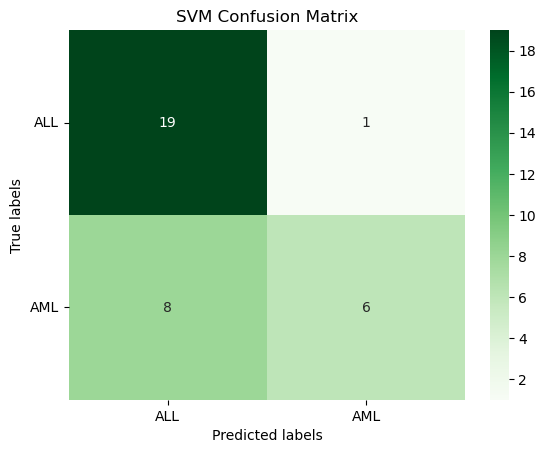

In [39]:
# Set random seed for reproducibility
random.seed(40)
np.random.seed(40)

# Parameter grid
svm_param_grid = {
    'C':[0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.001, 0.00001, 10],
    'kernel':['linear','rbf','poly'],
    'decision_function_shape': ['ovo', 'ovr']
}

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_ov, y_train_ov)

# Print the best parameters found by the grid search
print('Best parameters:\n', svm_grid.best_params_)

# Select the best SVC model
best_svc = svm_grid.best_estimator_

# Make predictions using the optimized parameters
svm_pred = best_svc.predict(normalized_X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, svm_pred)
print('SVM accuracy:', round(accuracy,3))

# Compute confusion matrix
cm_svm = confusion_matrix(y_test, svm_pred)

# Extract true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) from confusion matrix
TN, FP, FN, TP = cm_svm.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP / (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN / (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax=ax, fmt='g', cmap='Greens') 

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(['ALL', 'AML']) 
ax.yaxis.set_ticklabels(['ALL', 'AML'], rotation=360)

## Results

- Naive Bayes Accuracy: 0.735
- Logistic Regression Accuracy: 0.765
- SVM Accuracy: 0.794
Logistic Regression showed strength in correctly identifying AML, while SVM showed better performance at correctly identifying ALL

*Limitations* : Results fluctuated in each iteration for logistic regression and SVM. Possible solution would be setting random seed.

## Reference

Golub, T. R., Slonim, D. K., Tamayo, P., Huard, C., Gaasenbeek, M., Mesirov, J. P., Coller, H., Loh, M. L., Downing, J. R., Caligiuri, M. A., Bloomfield, C. D., & Lander, E. S. (1999). Molecular classification of cancer: Class Discovery and class prediction by Gene Expression Monitoring. Science, 286(5439), 531–537. https://doi.org/10.1126/science.286.5439.531

Varimp. (2019, April 2). Gene expression classification. Kaggle. https://www.kaggle.com/code/varimp/gene-expression-classification

Crawford, C. (2017, August 8). Gene expression dataset (golub et al..). Kaggle. https://www.kaggle.com/datasets/crawford/gene-expression/code?datasetId=1868&sortBy=voteCount

Nageshsingh. (2020, December 31). Classification of cancer. Kaggle. https://www.kaggle.com/code/nageshsingh/classification-of-cancer